In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sys
from datetime import datetime


from functions.data_loading import get_flight_persistence, get_condensed_distance_matrix, get_data_range, get_filtered_data_range
from functions.objects import PersistenceData
from functions.plotting import plot_cluster_scatters, plot_cluster_pers_diagrams
from functions.hartigan import hartigan_index

from traffic.core import Traffic, Flight
from matplotlib import pyplot as plt
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

from sklearn import preprocessing
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn_extra.cluster import KMedoids
from sklearn.metrics.pairwise import euclidean_distances

from collections import Counter

sys.setrecursionlimit(10000)

In [2]:
origin = "oslo"
destination = "bergen"

#unfiltered_flights, file_name = get_data_range(origin, destination, datetime(year=2023, month=1, day=1), datetime(year=2024, month=1, day=1), load_results=True)
#file_name = "oslo-bergen-2023-01-01-2024-01-01.pkl"
#filtered_flights, file_name = get_filtered_data_range(None, file_name, complete_flight_filter(origin, destination, 0.75), load_results=True)
file_name = "complete_flights/oslo-bergen-2023-01-01-2024-01-01.pkl"
way_1_trees, way_1_paths, file_name = get_flight_persistence(None, file_name, load_results=True)

8054 before, 6948 after

In [3]:
origin = "bergen"
destination = "oslo"
#unfiltered_flights, file_name = get_data_range(origin, destination, datetime(year=2023, month=1, day=1), datetime(year=2024, month=1, day=1), load_results=True)
#filtered_flights, file_name = get_filtered_data_range(unfiltered_flights, file_name, complete_flight_filter(origin, destination, 0.75), load_results=True)
file_name = "complete_flights/bergen-oslo-2023-01-01-2024-01-01.pkl"
way_2_trees, way_2_paths, file_name = get_flight_persistence(None, file_name, load_results=True)

7779 before, 6866 after

In [2]:
6948 + 6866

13814

In [4]:
trees = way_1_trees + way_2_trees
paths = way_1_paths + way_2_paths
del way_1_trees, way_2_trees, way_1_paths, way_2_paths

condensed_distance_matrix = get_condensed_distance_matrix(trees, file_name, load_results=True)
distance_matrix = squareform(condensed_distance_matrix)

pers_data = PersistenceData(trees, paths, "LL")

clusterings = {}

In [5]:
def select_k_by_hartigan(clusterer_factory, data, distances = None, start_k=5, max_k=50, threshold=10.0, squared=False):
    """
    Returns (k_star, labels_k_star, history) where history is a list of (k, H_k).
    Chooses the *first* k with H_k <= threshold; if none, falls back to argmin(H_k).
    """
    history = []
    k = start_k
    if distances is None:
        distances = euclidean_distances(data)

    while k + 1 <= max_k:
        labels_k = clusterer_factory(k).fit_predict(data)
        labels_k1 = clusterer_factory(k + 1).fit_predict(data)

        Hk = hartigan_index(labels_k, labels_k1, distances, squared=squared)
        history.append((k, float(Hk)))

        if np.isfinite(Hk) and Hk <= threshold:
            final_labels = clusterer_factory(k).fit_predict(data)
            return k, final_labels, history

        k += 1

    # Fallback: pick k with minimal finite H_k (could be negative)
    finite_hist = [(kk, hh) for kk, hh in history if np.isfinite(hh)]
    if finite_hist:
        k_best, _ = min(finite_hist, key=lambda t: t[1])
        final_labels = clusterer_factory(k_best).fit_predict(data)
        return k_best, final_labels, history

    return None, None, history  # nothing usable

In [6]:
class LinkageClustering:
    def __init__(self, n_clusters, method="complete", depth=2):
        self.n_clusters = n_clusters
        self.method = method
        self.depth = depth
        self.labels_ = None

    def fit(self, X, y=None):
        # Accept either condensed (1D) or square (2D) distance matrix
        X = np.asarray(X)
        if X.ndim == 2 and X.shape[0] == X.shape[1]:
            X = squareform(X, checks=False)

        Z = linkage(X, method=self.method)
        self.labels_ = fcluster(
            Z, t=self.n_clusters, criterion="maxclust", depth=self.depth
        )
        return self

    def fit_predict(self, X, y=None):
        return self.fit(X, y).labels_


def Linkage_factory(k, method="complete", depth=2):
    return LinkageClustering(n_clusters=k, method=method, depth=depth)

def KMedoids_factory(k, random_state=42):
    return KMedoids( n_clusters=k, metric="precomputed", init="k-medoids++", random_state=random_state)

def KMeans_factory(k, random_state=42):
    return KMeans(n_clusters=k, init="k-means++", random_state=random_state)

In [7]:
name, factory = ("KMedoids", lambda k: KMedoids_factory(k))
k_star, _, _ = select_k_by_hartigan(
    lambda k: KMedoids_factory(k),
    distance_matrix,
    distances=distance_matrix,
    start_k=2, max_k=50, threshold=10.0,
    squared=False
)
print(f"Hartigan chose k={k_star}")

clustering = KMedoids_factory(k_star).fit_predict(distance_matrix)
clusterings["KMedoids"] = clustering

Hartigan chose k=48


In [8]:
k_star, _, _ = select_k_by_hartigan(
    lambda k: Linkage_factory(k, method="complete", depth=2),
    condensed_distance_matrix,
    distances=distance_matrix,
    start_k=2, max_k=50, threshold=10.0,
    squared=False
)
print(f"Hartigan chose k={k_star}")

clustering = Linkage_factory(k_star, method="complete", depth=2).fit_predict(condensed_distance_matrix)
clusterings["Linkage"] = clustering

Hartigan chose k=28


In [9]:
normalizer = preprocessing.StandardScaler()
X_std = normalizer.fit_transform(pers_data.stats)

k_star, _, _ = select_k_by_hartigan(
    lambda k: KMeans_factory(k),
    X_std,
    start_k=2, max_k=50, threshold=10.0,
    squared=False
)
print(f"Hartigan chose k={k_star}")

clustering = KMeans_factory(k_star).fit_predict(X_std)
clusterings["KMeans"] = clustering

Hartigan chose k=48


In [10]:
def relabel_by_size(labels, keep_noise=True):
    a = np.asarray(labels)
    uniq, cnt = np.unique(a, return_counts=True)  # uniq is sorted ascending

    if keep_noise and (-1 in uniq):
        mask = (uniq != -1)
        # Sort by count desc, then by label asc for deterministic ties
        order = np.lexsort((uniq[mask], -cnt[mask]))
        ordered_labels = uniq[mask][order]
        mapping = {int(old): i for i, old in enumerate(ordered_labels)}
        mapping[-1] = -1
    else:
        order = np.lexsort((uniq, -cnt))          # count desc, label asc
        ordered_labels = uniq[order]
        mapping = {int(old): i for i, old in enumerate(ordered_labels)}

    # Fast map without np.vectorize
    out = np.empty_like(a, dtype=int)
    for old, new in mapping.items():
        out[a == old] = new
    return out

sorted_clusterings = {}
for key, clustering in clusterings.items():
    clustering = relabel_by_size(clustering)
    sorted_clusterings[key] = clustering

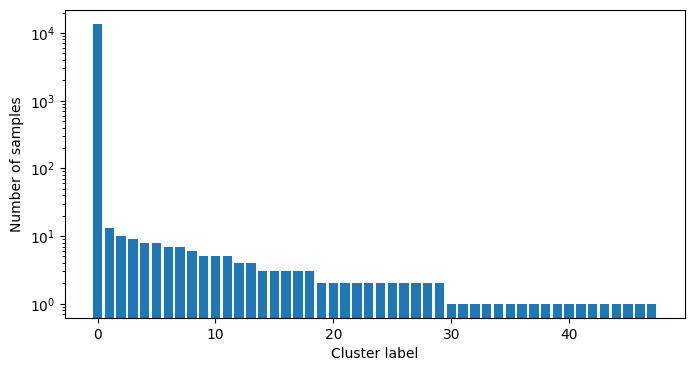

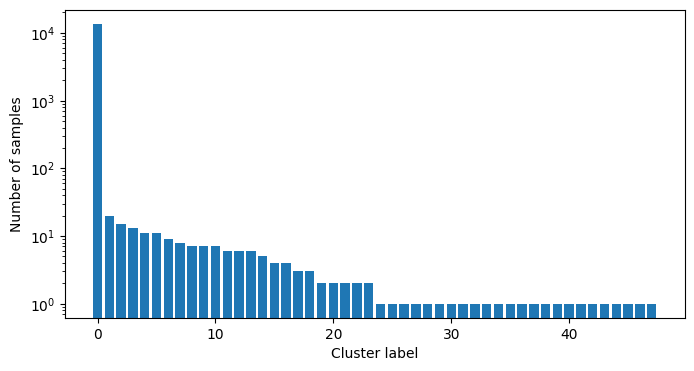

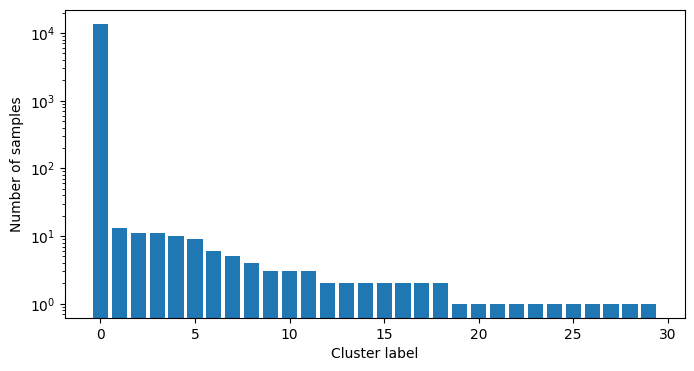

In [25]:
for method, clustering in sorted_clusterings.items():
    counts = Counter(clustering)  # cluster label → count
    labels, values = zip(*sorted(counts.items(), key=lambda x: x[0]))

    plt.figure(figsize=(8, 4))
    plt.bar(labels, values)
    plt.yscale("log")
    #plt.title(f"Cluster distribution for {key.capitalize()}")
    plt.xlabel("Cluster label")
    plt.ylabel("Number of samples")
    plt.savefig(f"./Thesis Plots/Experiment1/{method}_hist.svg", format="svg", dpi=1000, bbox_inches='tight')

    plt.show

In [20]:
for key, clustering in sorted_clusterings.items():
    print(f"{key.capitalize()}:")
    print(" | ".join([f"{i}: {count}" for i, count in sorted(Counter(clustering).items(), key=lambda x: x[0])]))

Kmedoids:
0: 13668 | 1: 13 | 2: 10 | 3: 9 | 4: 8 | 5: 8 | 6: 7 | 7: 7 | 8: 6 | 9: 5 | 10: 5 | 11: 5 | 12: 4 | 13: 4 | 14: 3 | 15: 3 | 16: 3 | 17: 3 | 18: 3 | 19: 2 | 20: 2 | 21: 2 | 22: 2 | 23: 2 | 24: 2 | 25: 2 | 26: 2 | 27: 2 | 28: 2 | 29: 2 | 30: 1 | 31: 1 | 32: 1 | 33: 1 | 34: 1 | 35: 1 | 36: 1 | 37: 1 | 38: 1 | 39: 1 | 40: 1 | 41: 1 | 42: 1 | 43: 1 | 44: 1 | 45: 1 | 46: 1 | 47: 1
Kmeans:
0: 13635 | 1: 20 | 2: 15 | 3: 13 | 4: 11 | 5: 11 | 6: 9 | 7: 8 | 8: 7 | 9: 7 | 10: 7 | 11: 6 | 12: 6 | 13: 6 | 14: 5 | 15: 4 | 16: 4 | 17: 3 | 18: 3 | 19: 2 | 20: 2 | 21: 2 | 22: 2 | 23: 2 | 24: 1 | 25: 1 | 26: 1 | 27: 1 | 28: 1 | 29: 1 | 30: 1 | 31: 1 | 32: 1 | 33: 1 | 34: 1 | 35: 1 | 36: 1 | 37: 1 | 38: 1 | 39: 1 | 40: 1 | 41: 1 | 42: 1 | 43: 1 | 44: 1 | 45: 1 | 46: 1 | 47: 1
Linkage:
0: 13711 | 1: 13 | 2: 11 | 3: 11 | 4: 10 | 5: 9 | 6: 6 | 7: 5 | 8: 4 | 9: 3 | 10: 3 | 11: 3 | 12: 2 | 13: 2 | 14: 2 | 15: 2 | 16: 2 | 17: 2 | 18: 2 | 19: 1 | 20: 1 | 21: 1 | 22: 1 | 23: 1 | 24: 1 | 25: 1 | 26: 1 | 

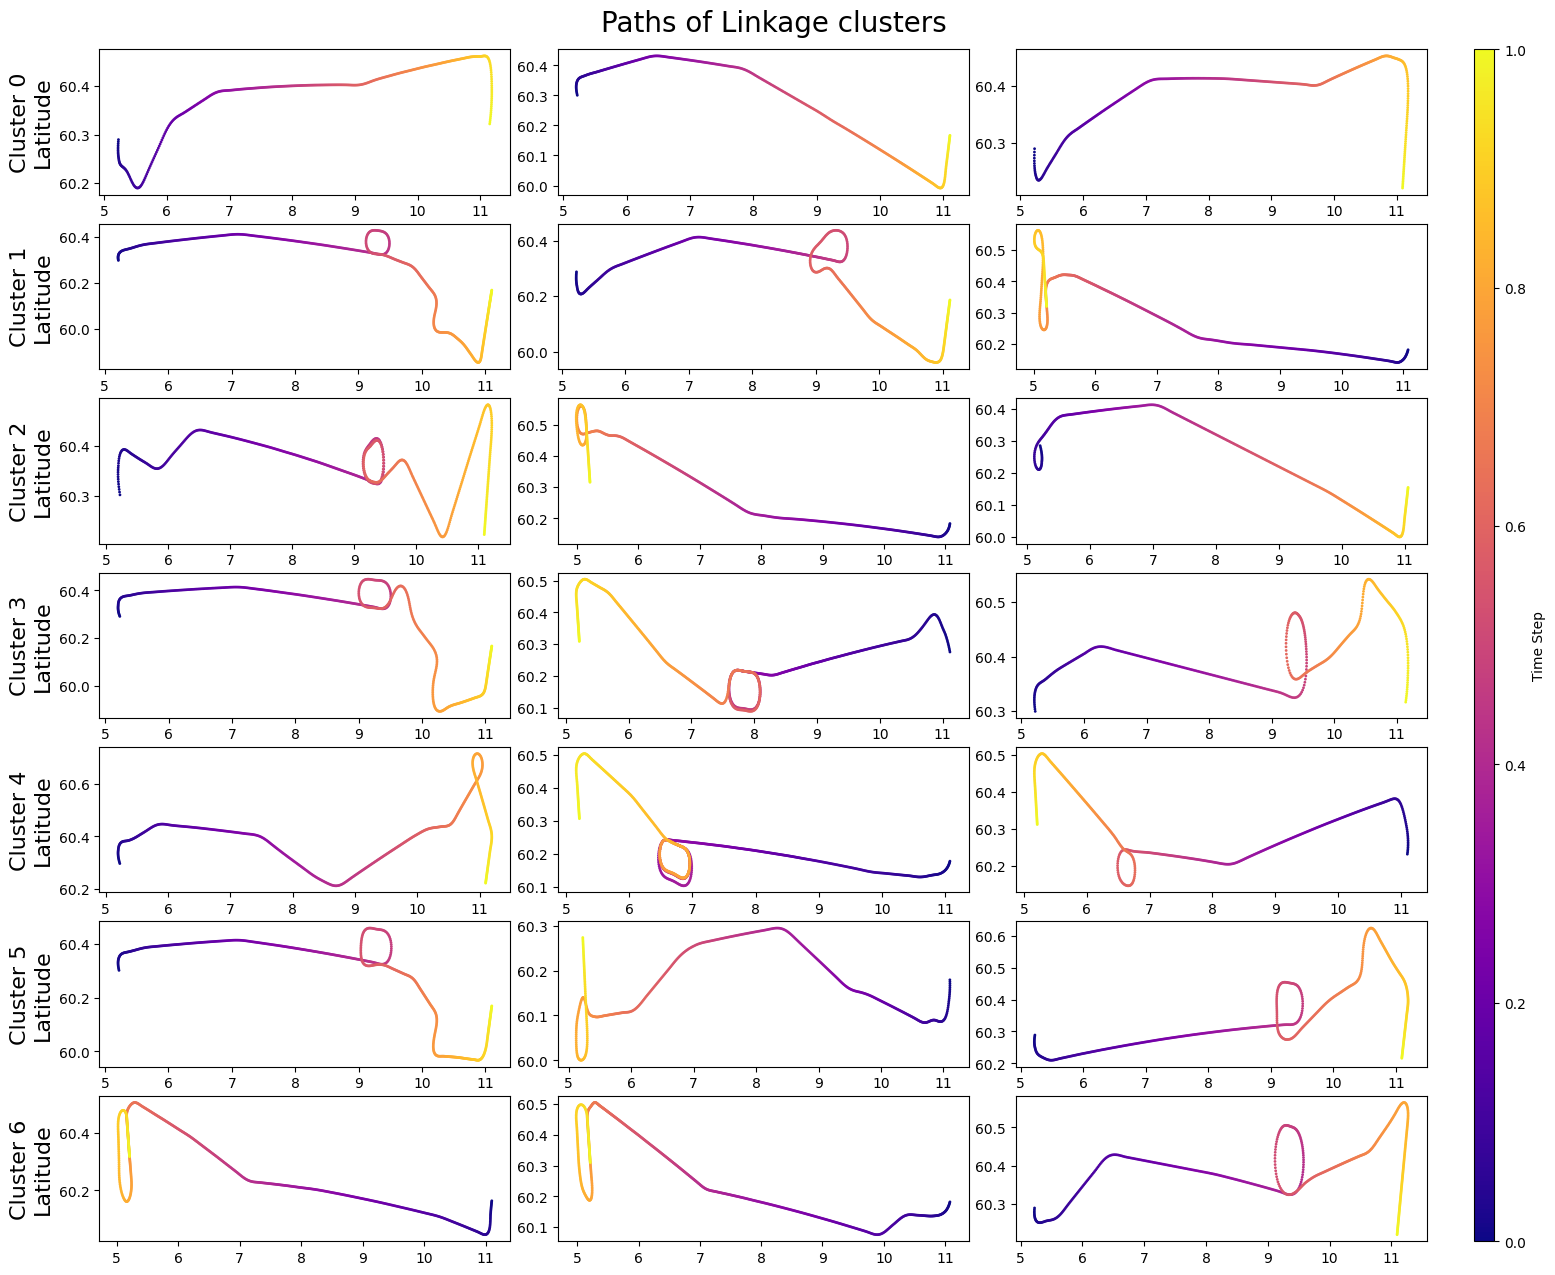

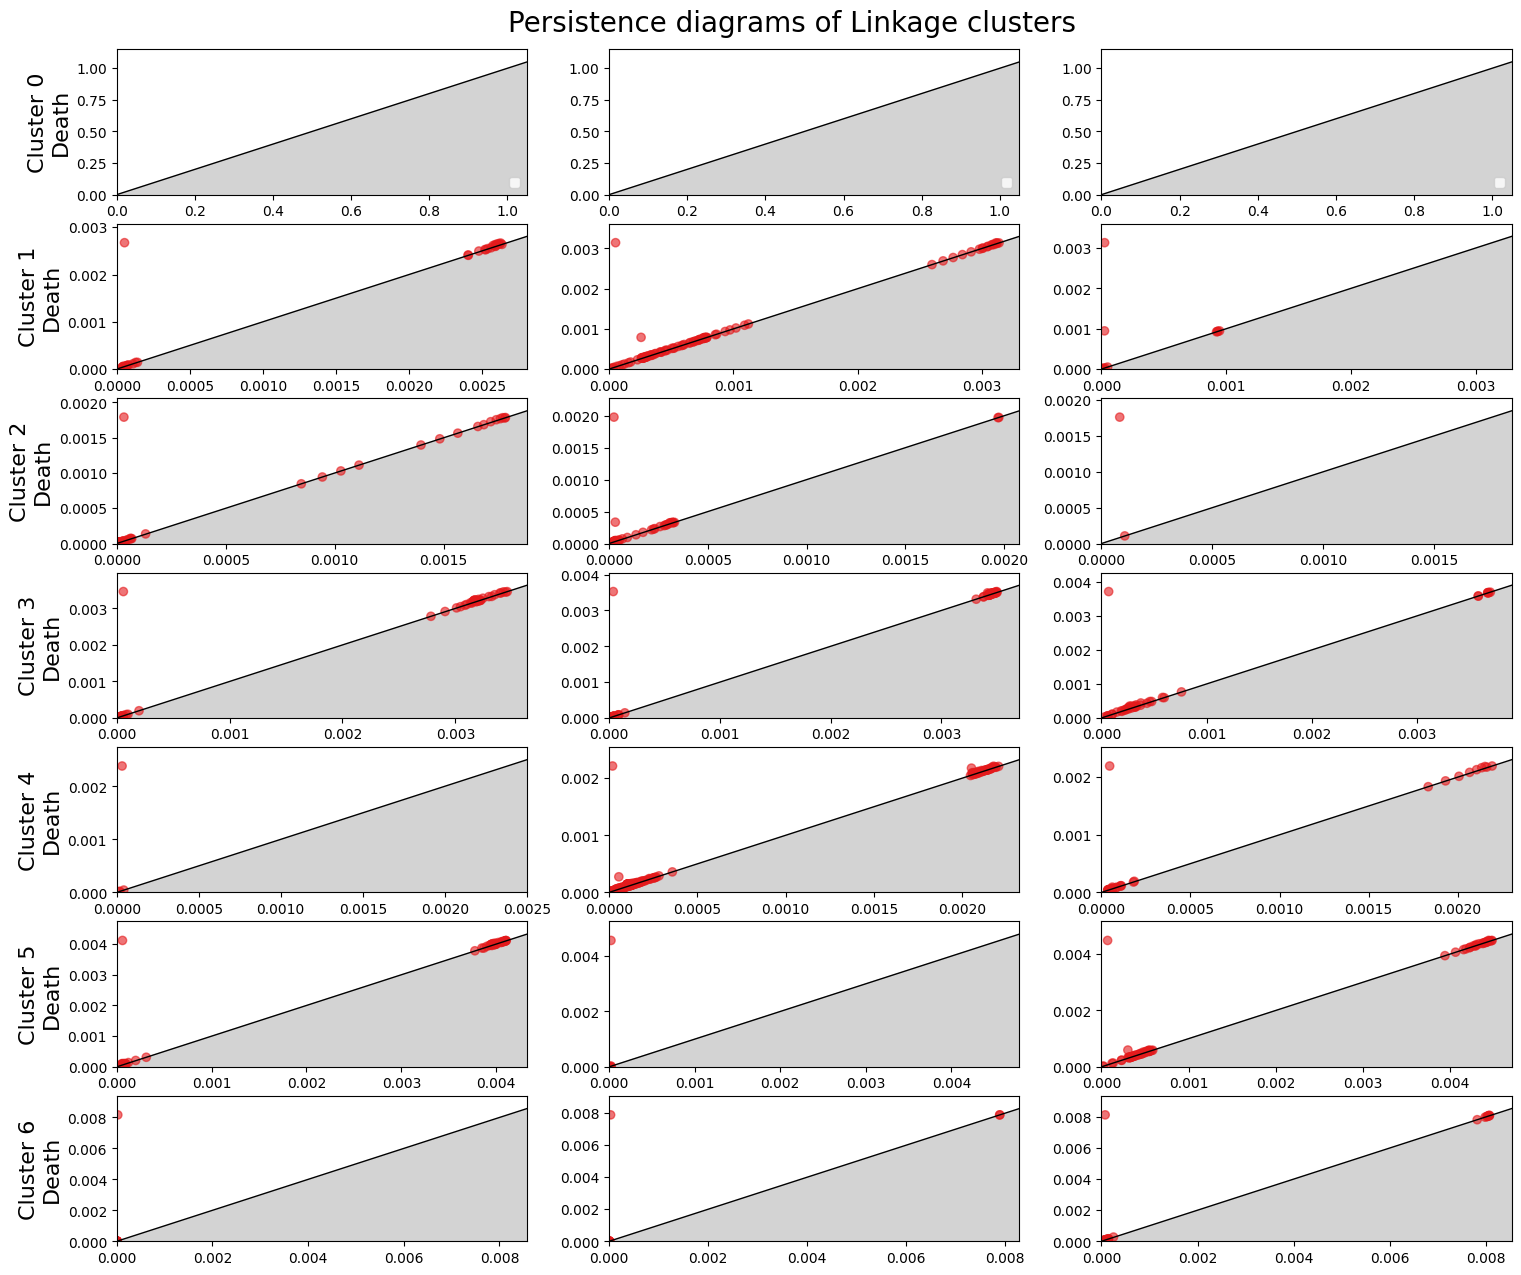

In [49]:
cluster_methods = list(sorted_clusterings.items())
sample_count = 3
max_clusters = 7
method, clustering = cluster_methods[2]

fig = plot_cluster_scatters(clustering, pers_data, method, sample_count, max_clusters)
fig.savefig(f"./Thesis Plots/Experiment1/{method}_scatters.svg", format="svg", dpi=1000, bbox_inches='tight')

fig = plot_cluster_pers_diagrams(clustering, pers_data, method, sample_count, max_clusters)
fig.savefig(f"./Thesis Plots/Experiment1/{method}_diagrams.svg", format="svg", dpi=1000, bbox_inches='tight')

In [56]:
from functions.VoI import variation_of_information
from itertools import combinations

names = sorted_clusterings.items()
for i, j in combinations(names, 2):
    i_name, i_cluster = i
    j_name, j_cluster = j
    print(i_name, j_name, variation_of_information(i_cluster, j_cluster, 2))

KMedoids KMeans 0.06857129665008854
KMedoids Linkage 0.04488694090903059
KMeans Linkage 0.09559331570288115


In [34]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# distance_matrix should be a 2D NumPy array
tsne = TSNE(metric='precomputed', perplexity=2, random_state=41, init='random')

embedding = tsne.fit_transform(distance_matrix)

C:\Users\tobso\AppData\Local\Temp\ipykernel_14728\1081868444.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


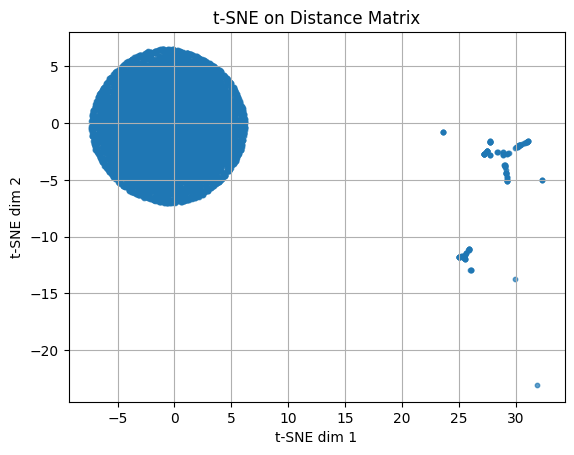

In [35]:
fig, ax = plt.subplots()
ax.scatter(embedding[:, 0], embedding[:, 1], s=10, alpha=0.7)
ax.set_title("t-SNE on Distance Matrix")
ax.set_xlabel("t-SNE dim 1")
ax.set_ylabel("t-SNE dim 2")
x_lim, y_lim = ax.get_xlim(), ax.get_ylim()
ax.grid(True)
fig.show()
fig.savefig(f"./Thesis Plots/Experiment1/TSNE_plot.svg", format="svg", dpi=1000, bbox_inches='tight')

C:\Users\tobso\AppData\Local\Temp\ipykernel_14728\752108501.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


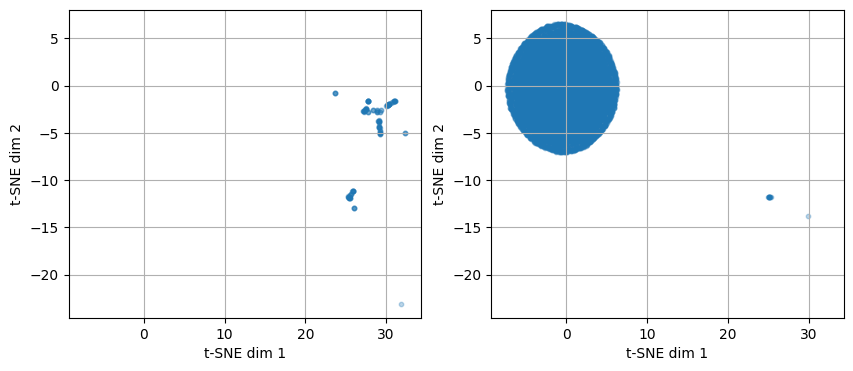

In [43]:
name, clustering = cluster_methods[0]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
cluster = 0
ax[0].scatter(embedding[clustering != cluster, 0], embedding[clustering != cluster, 1], s=10, alpha=0.3)
ax[0].set_xlabel("t-SNE dim 1")
ax[0].set_ylabel("t-SNE dim 2")
ax[0].set_xlim(x_lim)
ax[0].set_ylim(y_lim)
ax[0].grid(True)

ax[1].scatter(embedding[clustering == cluster, 0], embedding[clustering == cluster, 1], s=10, alpha=0.3)
ax[1].set_xlabel("t-SNE dim 1")
ax[1].set_ylabel("t-SNE dim 2")
ax[1].set_xlim(x_lim)
ax[1].set_ylim(y_lim)
ax[1].grid(True)
fig.show()

fig.savefig(f"./Thesis Plots/Experiment1/{name}_cluster_TSNE.svg", format="svg", dpi=300, bbox_inches='tight')

C:\Users\tobso\AppData\Local\Temp\ipykernel_6184\40843505.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


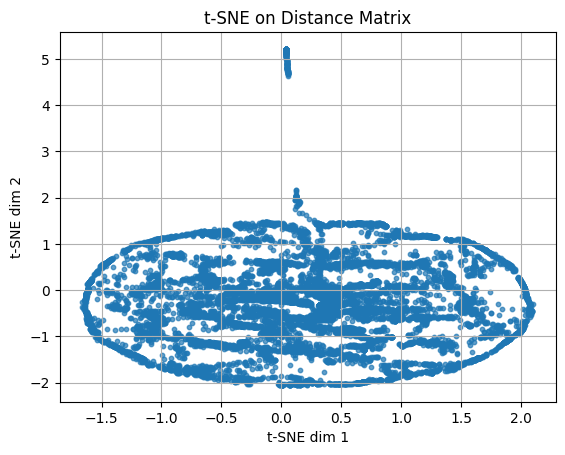

In [14]:
fig, ax = plt.subplots()
ax.scatter(embedding[:, 0], embedding[:, 1], s=10, alpha=0.7)
ax.set_title("t-SNE on Distance Matrix")
ax.set_xlabel("t-SNE dim 1")
ax.set_ylabel("t-SNE dim 2")
x_lim, y_lim = ax.get_xlim(), ax.get_ylim()
ax.grid(True)
fig.show()

In [15]:
mask = embedding[:, 1] >= 4
idx = np.flatnonzero(mask)
sub = embedding[idx]

# choose what “max/min” means — here, by x (column 0)
max_flight    = idx[np.argmax(sub[:, 0])]
min_flight    = idx[np.argmin(sub[:, 0])]
middle_flight = idx[np.argmin(np.abs(sub[:, 0] - np.median(sub[:, 0])))]

C:\Users\tobso\Desktop\programering\masters-thesis\functions\gudhi_persistence_plotting.py:105: UserWarning: This function is not available.
ModuleNotFoundError: No module named 'matplotlib'.
  warnings.warn(f"This function is not available.\nModuleNotFoundError: No module named '{import_error.name}'.")


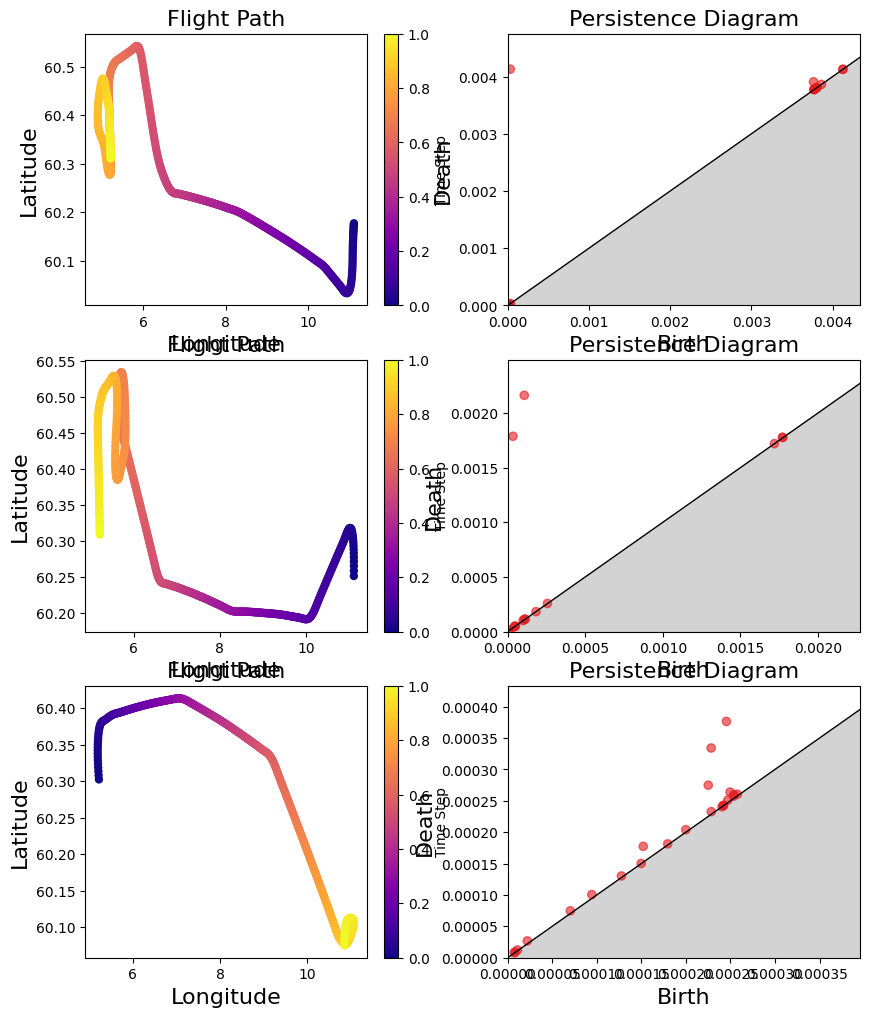

In [16]:
interesting_flights = embedding[:, 1] <= 4

fig, ax = plt.subplots(3, 2, figsize=(10, 12))
for i, flight_index in enumerate([min_flight, middle_flight, max_flight]):
    pers_data.plot_raw_path(ax[i, 0], flight_index)
    pers_data.plot_persistence(ax[i, 1], flight_index)

In [17]:
mask = embedding[:, 1] <= 4
idx = np.flatnonzero(mask)          # row indices of "interesting" points
sub = embedding[idx]                # (n_sel, 2)

# choose what “max/min” means — here, by x (column 0)
max_flight    = idx[np.argmax(sub[:, 0])]
min_flight    = idx[np.argmin(sub[:, 0])]
middle_flight = idx[np.argmin(np.abs(sub[:, 0] - np.median(sub[:, 0])))]

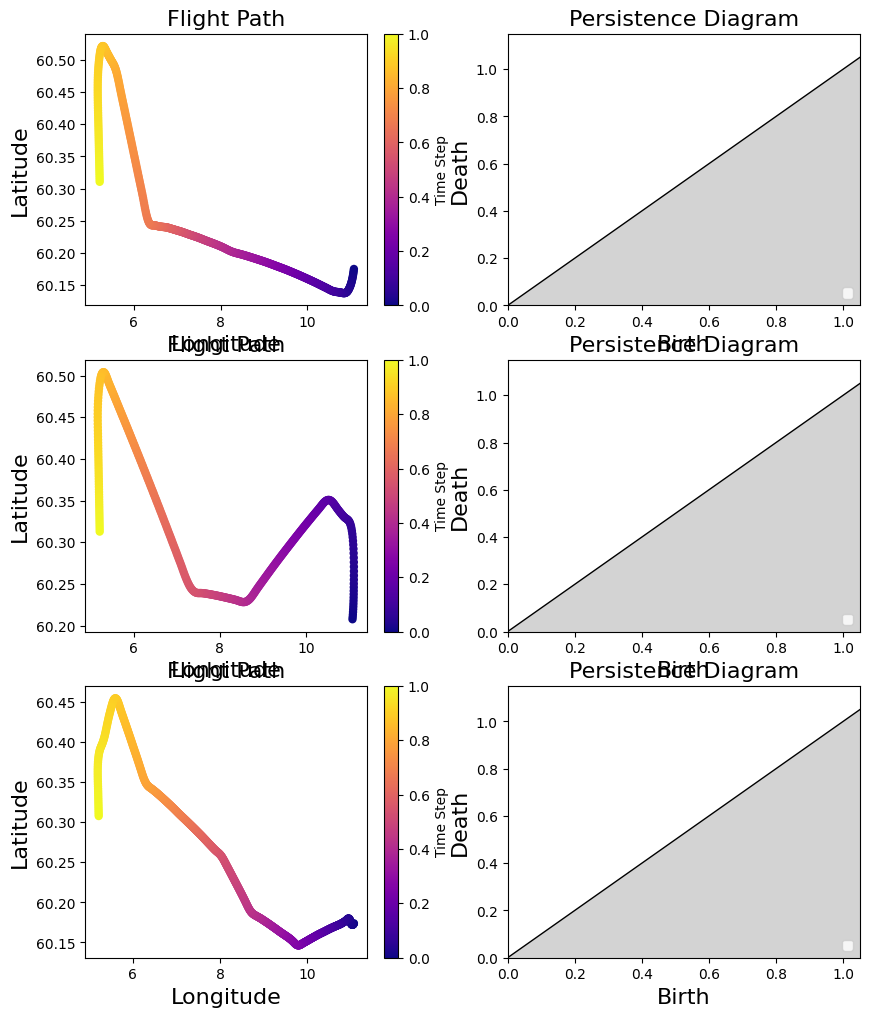

In [18]:
interesting_flights = embedding[:, 1] <= 4

fig, ax = plt.subplots(3, 2, figsize=(10, 12))
for i, flight_index in enumerate([min_flight, middle_flight, max_flight]):
    pers_data.plot_raw_path(ax[i, 0], flight_index)
    pers_data.plot_persistence(ax[i, 1], flight_index)

In [19]:
mask = embedding[:, 1] <= 4
idx = np.flatnonzero(mask)          # row indices of "interesting" points
sub = embedding[idx]                # (n_sel, 2)

# choose what “max/min” means — here, by x (column 0)
max_flight    = idx[np.argmax(sub[:, 1])]
min_flight    = idx[np.argmin(sub[:, 1])]
middle_flight = idx[np.argmin(np.abs(sub[:, 1] - np.median(sub[:, 1])))]

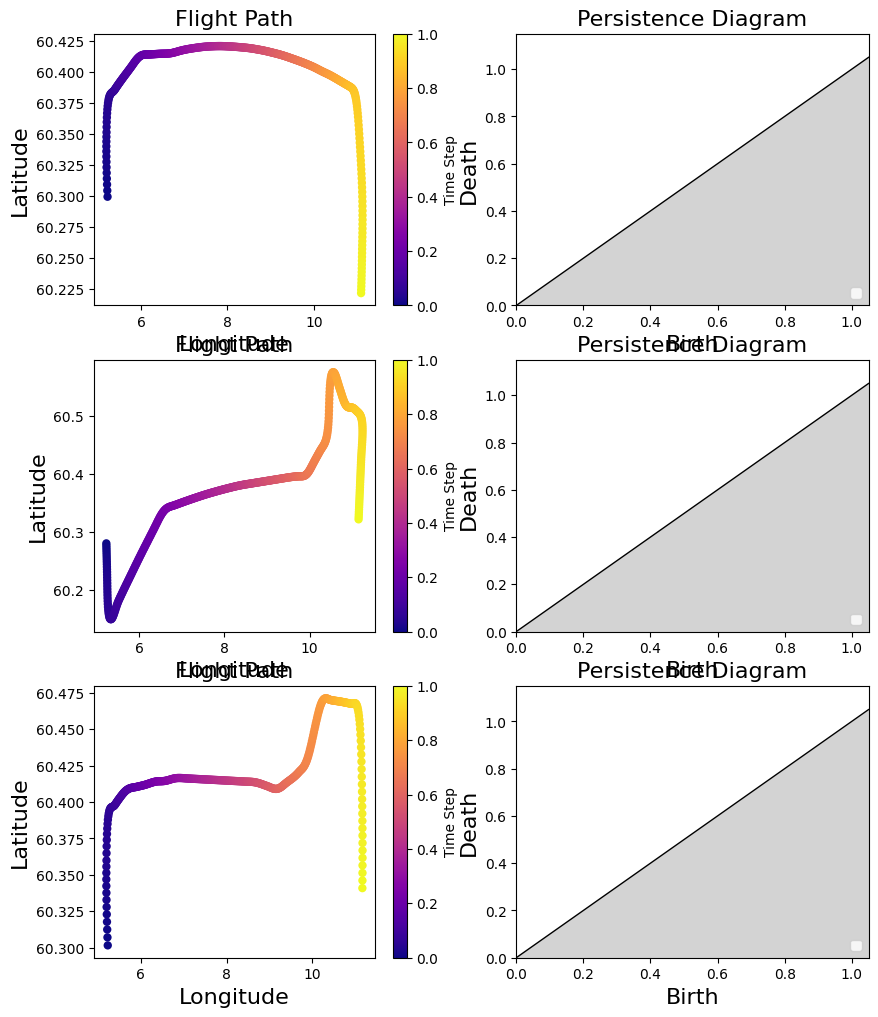

In [20]:
interesting_flights = embedding[:, 1] <= 4

fig, ax = plt.subplots(3, 2, figsize=(10, 12))
for i, flight_index in enumerate([min_flight, middle_flight, max_flight]):
    pers_data.plot_raw_path(ax[i, 0], flight_index)
    pers_data.plot_persistence(ax[i, 1], flight_index)